# Botnet Detection Over Networks Using Machine Learning
Nicolas Gardin
April 25, 2019


Introduction
--
Botnets are one of the most common and effective cyber-attacks used today. This project aimed to develop a predictive model for detecting botnet activity over a network using supervised machine learning in Python. This was done by leveraging pySpark to allow for optimal efficiency and distribution of processing with very large datasets. The datasets obtained were gathered from the CTU-13 Malware Capture Project and consisted of approximately 20 million network flows from 13 scenarios. The project consisted of 4 general stages: Learning resources, preprocessing and discretization, feature generation, model execution and results.
   

Learning Resources
--
The first step of this project consisted of studying literature and reports on the analysis of botnet behaviour over networks. Through this, the best approaches for determining how to identify botnets were obtained and later applied through feature generation. 

This project took a traffic analysis approach, which was built of the knowledge that botnets generally show similar traffic behaviour over a network.


Preprocessing and Discretization
--
Before the data is passed to the machine learning model for training and testing, processing needs to be done to ensure we are not passing any irrelevant / unwanted data. 

The following steps were taken for preprocessing:

    1) Column StartTime converted into type Timestamp
    2) Columns Dir, sTos and dTos eliminated
    3) Eliminated any rows having NULL values in srcAddr, Sport, Dport, or dstAddr 
    4) Eliminated any IPv6 addresses from columns Sport and Dport
    4) Number of columns and rows outputted

In [ ]:
#Preprocessing.py

def toTimeStamp(dataframe):
    df = dataframe.withColumn("StartTime", to_timestamp(dataframe.StartTime, "yyyy/MM/dd hh:mm:ss")) #.SSS
    return df


def removeColumns(dataframe, cols):
    dataframe = dataframe.drop(*cols)
    return dataframe


def removeNullRows(dataframe, col): 
    df = dataframe.na.drop(subset=col)
    return df


def removeIPV6(dataframe):
    df = dataframe.filter(~dataframe['Sport'].contains('0x')) 
    df = dataframe.filter(~dataframe['Dport'].contains('0x'))
    return df


The following steps were taken for discretization: 

    1) Columns named sport_disc and dport_disc were created; containing the bin number of column sport and dport            after discretization (10 bins were used)
    2) Columns totBytes, totPkts srcBytes were discretized (20 bins were used)
    3) Encoded the label, {Background and Normal = 0}, {Botnet = 1}
    4) Proto column was converted into numerical values, {tcp=1, upd=2, arp=3...}
        

In [ ]:
#Discretization.py

def bucketizeCol(df, bucketNum, colName, newCol):
    discretizer = QuantileDiscretizer(numBuckets=bucketNum, inputCol=colName, outputCol=newCol)
    df = discretizer.fit(df).transform(df)
    df = df.withColumn(newCol, df[newCol].cast(IntegerType()))
    return df


def encodeProtocol(df):
    df = df.withColumn('Proto', when(df['Proto'].contains("tcp"), 1) \
                                .when(df['Proto'].contains("rtp"), 2) \
                                .when(df['Proto'].contains("udt"), 3) \
                                .when(df['Proto'].contains("udp"), 4) \
                                .when(df['Proto'].contains("rtcp"), 5).otherwise(0))
    return df


def encodeLabel(df):
    df = df.withColumn('Label', when(df['SrcAddr'] == '147.32.84.165', 1) \
                                .when(df['SrcAddr'] == '147.32.84.191', 1) \
                                .when(df['SrcAddr'] == '147.32.84.192', 1) \
                                .when(df['SrcAddr'] == '147.32.84.193', 1) \
                                .when(df['SrcAddr'] == '147.32.84.204', 1) \
                                .when(df['SrcAddr'] == '147.32.84.205', 1) \
                                .when(df['SrcAddr'] == '147.32.84.206', 1) \
                                .when(df['SrcAddr'] == '147.32.84.207', 1) \
                                .when(df['SrcAddr'] == '147.32.84.208', 1) \
                                .when(df['SrcAddr'] == '147.32.84.209', 1).otherwise(0))
    return df


Feature Generation
--
Botnet activity generally consists of making many attempts to make connections in short periods of time. This may be from C&C, port scanning, etc. Feature generation takes advantage of this knowledge and computes features that will help the machine learning model better predict whether activity looks similar to that of a botnet. A rolling window of 600 seconds was used to compute the time-based features. The following steps were taken:

    How many times the srcAddr has appeared in the last X seconds.
    For any of the flow records that srcAddr has appeared within the last X seconds:
    
        1. count the distinct destination ports
        2. count the distinct destination addresses
        3. count the distinct source ports
        4. average the packets
        5. average the bytes

     Repeat steps above for any of the flow records that dstAddr has 
     appeared within the last X minutes.

     Repeat steps above for any of the flow records that srcAddr AND dstAddr
     has appeared within the last X minutes: 

     Once TotPkts, TotBytes, and AvgBytes have been added, they are bucketized
     (limiting the number of branches in the ML model)
     
**Showing code for srcAddr features, code for dstAddr and srcDstAddr is similar**

In [ ]:
#FeatureGeneration.py

def srcAddr_timeBasedFeatures(df, window):

    #------ Find initial srcAddr results as df2 (all flows within the window) ----------
    windowSpec = Window() \
        .orderBy(df['StartTime'].cast('long')) \
        .rangeBetween(-window, 0) \
        .partitionBy(df['SrcAddr'])

    df2 = df.select('*') \
        .withColumn('num_SrcAddr', func.count('SrcAddr').over(windowSpec))

    #----- Compute features based on results from df2 as df3 -----------------
    df3 = df2.select('*') \
        .withColumn('Src_Dist_Sport', func.size(func.collect_set('Sport').over(windowSpec))) \
        .withColumn('Src_Dist_Dport', func.size(func.collect_set('Dport').over(windowSpec))) \
        .withColumn('Src_Dist_DestAddr', func.size(func.collect_set('DstAddr').over(windowSpec))) \
        .withColumn('Src_Avg_Pkts', func.avg('TotPkts').over(windowSpec).cast(IntegerType())) \
        .withColumn('Src_Avg_Bytes', func.avg('TotBytes').over(windowSpec).cast(IntegerType()))

    return df3



Model Execution and Results
--
Now that the Preprocessing, Discretization, and Feature Generation are finished, the data is ready to be passed to the machine learning classifier, trained, and tested. A decision tree model was implemented and the data results were outputted to the console. 

The training and testing sets were split approximately 14M to 3.2M rows respectively, as seen in the output results shown below. Three types of machine learning models were tested: Decision Tree (DT), Random Forest (RF), Gradient Boosting (GBT).

Accuracy
--
Accuracy = 1.0 - test error

   **DT: 1.0 - 0.0218   =   97.8%**

   **RF: 1.0 -  0.0422   =   95.8%**

   **GBT: 1.0 - 0.0192   =   98.1%**
   


In [ ]:
#Training_Testing.py

def createVectorColumn(df, curSet):

    numericCols = ['Proto', 'Sport_Disc', 'Dport_Disc', 'TotPkts_Disc', 'TotBytes_Disc', 
            'SrcBytes_Disc', 'num_DstAddr', 'Dst_Dist_Sport',
            'Dst_Dist_Dport', 'num_SrcAndDst', 'SrcDst_Dist_Sport', 
            'SrcDst_Dist_Dport', 'num_SrcAddr_Disc', 
            'Src_Dist_Sport_Disc','Src_Dist_Dport_Disc', 
            'Src_Dist_DestAddr_Disc', 'Src_Avg_Pkts_Disc', 
            'Src_Avg_Bytes_Disc', 'Dst_Avg_Pkts_Disc', 'Dst_Avg_Bytes_Disc', 'SrcDst_Avg_Pkts_Disc', 
            'SrcDst_Avg_Bytes_Disc']
    stages = []

    # for all cols, assemble into a single vector column
    assembler = VectorAssembler(inputCols=numericCols, outputCol="features")
    stages += [assembler]

    # pipeline stages
    pipeline = Pipeline(stages = stages)

    pipelineModel = pipeline.fit(df)
    
    df = pipelineModel.transform(df)
    print("Finished classification model")
    return df


def decisionTree(train, test):

    dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 5)
    dtModel = dt.fit(train)
    predictions = dtModel.transform(test)
    # predictions.select('label', 'prediction').show(5)

    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator.evaluate(predictions)
    print("DT Test Error = %g " % (1.0 - accuracy))


def randomForest(train, test):

    rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
    rfModel = rf.fit(train)
    predictions = rfModel.transform(test)
    # predictions.select('label', 'prediction').show(5)

    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator.evaluate(predictions)
    print("RF Test Error = %g " % (1.0 - accuracy))


def gbt(train, test):
    
    gbt = GBTClassifier(maxIter=10)
    gbtModel = gbt.fit(train)
    predictions = gbtModel.transform(test)
    # predictions.select('label', 'prediction').show(5)

    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator.evaluate(predictions)
    print("GBT Test Error = %g " % (1.0 - accuracy))
    

**Console screenshot**

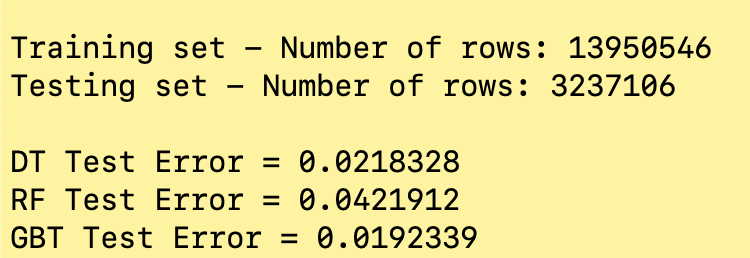

References
--

1.	Li, S. (2017, December 04). Solving A Simple Classification Problem with Python - Fruits Lovers' Edition. Retrieved from https://towardsdatascience.com/solving-a-simple-classification-problem-with-python-fruits-lovers-edition-d20ab6b071d2


2.	Nguyen, T. T., & Armitage, G. (2008). A survey of techniques for internet traffic classification using machine learning. IEEE Communications Surveys & Tutorials, 10(4), 56-76 2008. Retrieved from http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.498.2304&rep=rep1&type=pdf


3.	Tan, Steinbach, Kumar. (2004, April 18). Data Mining Classification: Basic Concepts, Decision Trees, and Modal Evaluation. Retrieved from https://www-users.cs.umn.edu/~kumar001/dmbook/dmslides/chap4_basic_classification.pdf


4.	A. J. Aviv and A. Haeberlen, “Challenges in experimenting with botnet detection systems,” in USENIX 4th CSET Workshop, San Francisco, CA, 2011.


5.	M. Tavallaee, N. Stakhanova, and A. A. Ghorbani, “Toward credible evaluation of anomaly-based intrusion-detection methods,” Systems, Man, and Cybernetics, Part C: Applications and Reviews, IEEE Transactions on, vol. 40, no. 5, pp. 516–524, 2010.


6.	D. Zhao, I. Traore, B. Sayed, W. Lu, S. Saad, A. Ghorbani, and D. Garant, “Botnet detection based on traffic behavior analysis and flow intervals,” Computers & Security, 2013.


7.	G. Szab ́o, D. Orincsay, S. Malomsoky, and I. Szab ́o, “On the validation of traffic classification algorithms,” in Passive and Active Network Measurement. Springer, 2008, pp. 72–81.


8.	M. Stevanovic and J. M. Pedersen, “Machine learning for identifying botnet network traffic,” Networking and Security Section, Department of Electronic Systems, Aalborg University, Tech. Rep., 2013.
